# Question Answer 2 (haystack v.1)

We will get back to the QA problem of yesterday, this time focusing on evaluating the retriver and reader separately, and fine-tuning a full pipeline.

## Reloading the dataset
I will not comment a lot here, as this is mostly work from yesterday. Instead of using Elasticsearch, however, we will play with InMemory store (given the size of the dataset, it should hardly matter).

We will also use a dense retriever instead of BM25.

In [1]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics", trust_remote_code = True)

from haystack.document_stores import InMemoryDocumentStore

# 384 is the dimension of the dense embedding that we will
document_store_dense = InMemoryDocumentStore(use_bm25 = False, embedding_dim = 384)



import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
from haystack import Document

for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [Document(content =  row["context"], 
             meta = {"item_id": row["title"], "question_id": row["id"], 
                     "split": split})
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store_dense.write_documents(
        docs, 
        index = "document" # The name of the table (think as SQL)
        )
print(f"Loaded {document_store_dense.get_document_count()} documents to dense")

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.ut

Loaded 1615 documents to BM25
Loaded 1615 documents to dense


To be able to use the dense embdding, we will need to update the retriever.

In [2]:
from haystack.nodes import EmbeddingRetriever

dense = EmbeddingRetriever(
    document_store = document_store_dense,
    embedding_model = "sentence-transformers/all-MiniLM-L6-v2",
    model_format = "sentence_transformers",
    use_gpu = True,
)

document_store_dense.update_embeddings(dense)


/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 51/51 [00:08<00:00,  6.36it/s]docs/s]
Documents Processed: 10000 docs [00:08, 1237.27 docs/s]         


## Evaluating retrievers
Here we will compare the two retrievers separately to see how well they perform. We need to update the book's code for that!

In [26]:
# Makes evaluation dataset.
eval_data = []
for i, row in dfs['test'].iterrows():
    # Deals with aswerable questions
    if len(row['answers.text']):
        eval_data.append({
            'query': row['question'],
            'item_id': row['title'],
            'expected': row['context']
        })
    # Unanswarable
    else:
        eval_data.append({
                'query': row['question'],
                'item_id': row['title'],
                'expected': ''
            })

Let us implement recall@1

Batches: 100%|██████████| 1/1 [00:00<00:00, 352.70it/s]


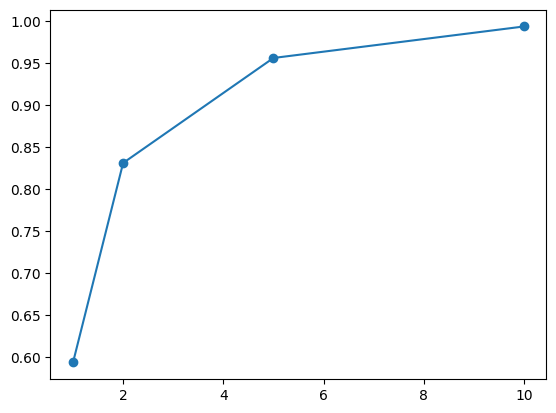

In [44]:
recalls = []
ks = [1, 2, 5, 10]
for k in ks:
    recall = 0
    questions_answered = 0

    for item in eval_data:
        retrieved_docs = dense.retrieve(
            item['query'], 
            top_k = k, # Retrieve top k documents
            filters={'item_id': item['item_id'], 'split': 'test'}
            )  
        retrieved_texts = [d.content for d in retrieved_docs]

        # Recall is the number of corrected retrieved in the expected set
        # Because the expected set is here just one document, it is easy
        retrieved_set = retrieved_texts[:k]

        # Deals with unsanswerable questions by skipping the rest of iteration
        if len(item['expected']) == 0:
            continue
        if item['expected'] in retrieved_set:
            recall += 1
        
        questions_answered += 1

    recalls.append(recall/questions_answered)

import matplotlib.pyplot as plt
plt.plot(ks, recalls, 'o-')
plt.show()

Nice!

## Reader

Let us evaluate the reader. This turns out to be very easy, as we can just reuse the SQUAD metric.

In [45]:
import evaluate

squad_metric = evaluate.load("squad")

We initialize the reader.

In [46]:
from haystack.nodes import TransformersReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length = 384
doc_stride = 128

reader = TransformersReader(
    model_name_or_path = model_ckpt,  # only this is needed
    max_seq_len = max_seq_length,
    doc_stride = doc_stride,
    use_gpu = True  # set to False if no GPU
)

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
eval_data = []
for i, row in dfs['test'].iterrows():
    # Deals with aswerable questions
    if len(row['answers.text']):
        eval_data.append({
            'query': row['question'],
            'expected': list(row['answers.text']),
            'start': list(row['answers.answer_start']),
            'context': row['context'],
            'id': row['id'],
        })
    # Unanswarable
    else:
        eval_data.append({
            'query': row['question'],
            'expected': [''],
            'start': [0],
            'context': row['context'],
            'id': row['id']
        })

In [65]:
preds = []
refs = []

for item in eval_data:
    pred = reader.predict(
        query = item['query'], 
        top_k = 1,
        documents = [Document(content =  item['context'])]
        )  

    pred = pred['answers']
    # Cannot evaluate with an empty string, so we give it a dummy
    if pred == []:
        pred = ''
    else:
        pred =  pred[0].answer
    
    
    preds.append({
        'id': item['id'],
        'prediction_text': pred
    })
    
    ctext = item['expected']
    cstart = item['start']

    refs.append({
        'id': item['id'],
        'answers': {'text': ctext, 
                    'answer_start': cstart}
    })

squad_metric.compute(predictions = preds, references = refs)

/home/hlovisie/venvs/torch-cuda/lib/python3.11/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


{'exact_match': 2.793296089385475, 'f1': 12.891644169881934}

As expected, we got the same results from yesterday. Nonetheless, these are a little worse than what is reported by the book. The reason can be due to implementation of SQUAD (we implemented using Hugging Face, whereas they use the old haystack implementation). Nonetheless, since we are about 1/2 of their result and, incidently, about these much questions are unswered in the datatset, it can be on how each implementation deals with unswerables. In any case, our goal is to check if domain adaptation would actually improve values, so let us check that. Moreover, independently, the big bottleneck in performance is still the reader.

## Domain adaptation

We will use the train dataset to finetune the model. Let us see how this looks like. First, we need some preprocessing, for which we will only use the book.

In [66]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

#hide_output
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)
     

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

In [67]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)
     

/tmp/ipykernel_13457/3282317967.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  groups = (df.groupby("title").apply(create_paragraphs)
/tmp/ipykernel_13457/3282317967.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  groups = (df.groupby("title").apply(create_paragraphs)
/tmp/ipykernel_13457/3282317967.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and

In [69]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

We can now finetune the reader. Instrad of using a transformer reader, we will need a FARMReader for this (Transformer readers do not fine-tune).

In [77]:
from haystack.nodes import FARMReader

reader = FARMReader(
    model_name_or_path="deepset/minilm-uncased-squad2",
    max_seq_len = 384,
    doc_stride = 128,
    use_gpu = False, # Not enough VRAM
)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now we train.

In [79]:
reader.train(
    data_dir=".",
    train_filename="electronics-train.json",
    dev_filename="electronics-validation.json",
    n_epochs=1,
    batch_size=4,   # smaller batch for CPU
    use_gpu=False,  # <-- this forces CPU training
    use_amp=False
)


Preprocessing dataset:   0%|          | 0/3 [00:00<?, ? Dicts/s]Answer 'These earbuds are nothing special. Their best attribute is that they are cheap. The sound from them is nothing special. In comparison to my standard white IPod buds these seem to emphasize the higher frequencies. There seems to be nothing happening in the bass range with these. I don't think they are efficient enough to have much bass at all. To be fair, my IPod buds overly emphasize bass so they are not that accurate either. I also compared these to a pricy Sennheiser set that I've owned for a couple of years and let's just say there is a reason why the Sennheisers cost more.Surely these Panasonic buds are very nice to use if you think they might get damaged somehow in use as it will not break your heart to have to replace them. These might be especially useful if you only listen to talk radio or have high frequency hearing loss. If you really like to listen to the most of your music and you must wear earbuds then

Let us see how the predictions look like now.

In [102]:
item = eval_data[-1]
pred = reader.predict(
        query = item['query'], 
        top_k = 1,
        documents = [Document(content =  item['context'])]
        )  
print('Question:', item['query'])
print('Expected:', item['expected'])
print('Predicted:', pred['answers'][0].answer)

item = eval_data[0]
pred = reader.predict(
        query = item['query'], 
        top_k = 1,
        documents = [Document(content =  item['context'])]
        )  
print('\n\nQuestion:', item['query'])
print('Expected:', item['expected'])
print('Predicted:', pred['answers'][0].answer)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 16.54 Batches/s]


Question: What about case?
Expected: ['The Gladius mini is a durable case', "the case is rather unattractive if you don't account the leather strap"]
Predicted: The Gladius mini is a durable case


Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  7.55 Batches/s]



Question: What is the tonal balance of these headphones?
Expected: ['I have been a headphone fanatic for thirty years']
Predicted: the overall octave-to-octave balance is excellent


Fells like we are good, in fact, even better than the annotators for some cases.

Time to evaluate quantitatively.

In [106]:
preds = []
refs = []

for item in eval_data:
    pred = reader.predict(
        query = item['query'], 
        top_k = 1,
        documents = [Document(content =  item['context'])]
        )  

    pred = pred['answers']
    # Cannot evaluate with an empty string, so we give it a dummy
    if pred == []:
        pred = ''
    else:
        pred =  pred[0].answer
    
    
    preds.append({
        'id': item['id'],
        'prediction_text': pred
    })
    
    ctext = item['expected']
    cstart = item['start']

    refs.append({
        'id': item['id'],
        'answers': {'text': ctext, 
                    'answer_start': cstart}
    })

squad_metric.compute(predictions = preds, references = refs)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 13.61 Batches/s]


{'exact_match': 18.435754189944134, 'f1': 27.26924471839593}

Wow, big improvements for a CPU training! Let us make a full pipe-line, with retriever, and evaluate the whole thing!

## Retriever + Reader

Again, this is basic code from yesterday.

In [107]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader = reader, retriever = dense)

In [108]:
k = 5
test_data = subjqa['test']
preds = []
refs = []
for rev in test_data:
    pred = pipe.run(query = rev['question'], 
                 params = {
                     "Retriever": {"top_k": k,
                                    "filters": {"item_id": [rev['title']], "split":["test"]}}, 
                                    "Reader": {"top_k": 1}
                                    }
                                    )
    pred = pred['answers']
    # Cannot evaluate with an empty string, so we give it a dummy
    if pred == []:
        pred = ''
    else:
        pred =  pred[0].answer
    
    
    preds.append({
        'id': rev['id'],
        'prediction_text': pred
    })
    
    if len(rev['answers']['text']) == 0:
        ctext = ['']
        cstart = [0]
    else:
        ctext = rev['answers']['text']
        cstart = rev['answers']['answer_start']

    refs.append({
        'id': rev['id'],
        'answers': {'text': ctext, 
                    'answer_start': cstart}
    })

squad_metric.compute(predictions = preds, references = refs)

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00, 13.14 Batches/s]


{'exact_match': 12.849162011173185, 'f1': 21.69476677550303}

Great, much better!